In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from PIL import Image
from torchvision.transforms import v2
from torchvision import tv_tensors

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# DATASET CLASS
class ParkingDataset(Dataset):
     #init func constructor
    def __init__(self, root, annFile, transforms=None):

        self.root = root #director path
        self.coco = COCO(annFile) #loading coco format file
        self.transforms = transforms
        all_ids = list(sorted(self.coco.imgs.keys())) #taking all image id s from coco annotations file
        self.ids = [] #id storing for only valid images

        print("file existing checking.....")
        for img_id in all_ids:

            img_info = self.coco.loadImgs(img_id)[0] # take image info
            path = img_info['file_name'] #image name
            full_path = os.path.join(self.root, path) #full name of image path

            # if image file exists and valid
            if os.path.exists(full_path):
                self.ids.append(img_id)
            else:
                # error if image is not valid
                print(f"Warning : {path} not valid...")

        print(f"check is completed. Total :{len(all_ids)} images , and  {len(self.ids)} : are valid.")

    # taking a sinle example
    def __getitem__(self, index):

        img_id = self.ids[index] #taking image with that index
        ann_ids = self.coco.getAnnIds(imgIds=img_id) # take all annotation ids for this image
        coco_annotation = self.coco.loadAnns(ann_ids) # get annotation details

        # gte image info
        img_info = self.coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        img = Image.open(os.path.join(self.root, path)).convert("RGB") # open image and convert to RGB

        boxes = []
        masks = []
        labels = []

        # iterate over annotations
        for ann in coco_annotation:
            # COCO bbox format: [xmin, ymin, width, height]
            xmin, ymin, w, h = ann['bbox']
            boxes.append([xmin, ymin, xmin + w, ymin + h]) #appropiate format for mask r cnn
            labels.append(ann['category_id']) # 1: empty, 2: occupied
            masks.append(self.coco.annToMask(ann)) #turn it to  mask for mask r cnn

        # if image is empty creating empty values zeros
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.as_tensor([], dtype=torch.int64)
            masks = torch.zeros((0, img.size[1], img.size[0]), dtype=torch.uint8)
        else: #convert tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

        # target for  tv_tensorsv2
        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=img.size[::-1]),
            "masks": tv_tensors.Mask(masks),
            "labels": labels,
            "image_id": torch.tensor([img_id])
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)

# Transfroms and resızes
def get_transform(train=True):
    transforms = []

    # (H=500, W=1100)
    transforms.append(v2.Resize((500, 1100)))
    transforms.append(v2.ToImage())

    if train:
        # in train mode augmentation
        transforms.append(v2.RandomHorizontalFlip(p=0.5))
        transforms.append(v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1))
        transforms.append(v2.RandomPerspective(distortion_scale=0.2, p=0.4))

        transforms.append(v2.RandomApply([v2.GaussianBlur(kernel_size=(5, 5))], p=0.05))
        transforms.append(v2.SanitizeBoundingBoxes()) # removing invalid bounding boxes after transform

    transforms.append(v2.ToDtype(torch.float32, scale=True))
    #composing all transforms
    return v2.Compose(transforms)







# directory paths
root_path = '/content/drive/MyDrive/test/'
ann_path = '/content/drive/MyDrive/test/_annotations.coco.json'

# Dataset
test_dataset = ParkingDataset(root_path, ann_path, transforms=get_transform(train=False))



print(f"Total image count: {len(test_dataset)}")


loading annotations into memory...
Done (t=2.43s)
creating index...
index created!
file existing checking.....
check is completed. Total :346 images , and  346 : are valid.
Total image count: 346


In [4]:
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator , RPNHead
def get_model_instance_segmentation(num_classes , freeze_backbone=True):
    # load a pretrained Mask R-CNN model with ResNet50-FPN backbone
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT,
        min_size=500,
        max_size=1100
    )



    # anchor size settins
    # 16 ve 32: for small boxes
    # 128, 256, 512, 1024: for large booxes
    anchor_sizes = ((16,), (32,), (64,), (128,), (256,))

    # aspect ratio settings
    # To cover horizontal, square, and vertical parking slots
    aspect_ratios = ((0.2, 1.0, 5.0),) * 5
    anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios) #create generator
    model.rpn.anchor_generator = anchor_generator #replace generator


    # RPN proposal tuning
    # ı had a problem about lot of samll boxes increased the number of candidates for large boxes
    model.rpn._pre_nms_top_n['training'] = 3000
    model.rpn._pre_nms_top_n['testing'] = 2000
    model.rpn._post_nms_top_n['training'] = 2000
    model.rpn._post_nms_top_n['testing'] = 1000


    # Box classification & regression head
    in_features = model.roi_heads.box_predictor.cls_score.in_features #same input feature
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace with correct number of classes

    # Mask prediction head
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)



    return model

In [5]:
from torch.utils.data import DataLoader

# test DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)))

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 3
model = get_model_instance_segmentation(num_classes) #get model

#my best model
model_path = "/content/drive/MyDrive/ParkModeli/best_model_val.pth"
model.load_state_dict(torch.load(model_path, map_location=device)) #upload weights
model.to(device)
model.eval() # test mode

print("Model loaded succesfully.")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:01<00:00, 173MB/s]


Model loaded succesfully.


In [ ]:
from tqdm import tqdm
def evaluate_raw_counting_error(model, data_loader, device, score_thresh=0.7):
  # score_thresh: confidence threshold (NO NMS, only score filtering)
    model.eval()
    total_gt_empty = 0
    total_pred_empty = 0
    total_gt_occupied = 0
    total_pred_occupied = 0

    print("raw box counting(without NMS)...")

    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = [img.to(device) for img in images]
            outputs = model(images) # get model predictions boxes, labels, and scores per image

            for target, output in zip(targets, outputs): # match each image's ground truth and its prediction
                #Ground Truth numbers
                gt_labels = target["labels"].cpu().numpy()
                total_gt_empty += np.sum(gt_labels == 1)
                total_gt_occupied += np.sum(gt_labels == 2)

                #model predicitons
                pred_scores = output["scores"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()

                # keep predictions above confidence threshold
                valid_preds = pred_labels[pred_scores > score_thresh]
                total_pred_empty += np.sum(valid_preds == 1)
                total_pred_occupied += np.sum(valid_preds == 2)

    # Report
    print("\n" + "="*30)
    print("count report")
    print("="*30)
    print(f"ground truth empty:  {total_gt_empty}")
    print(f"models empty:    {total_pred_empty} (error: %{abs(total_pred_empty-total_gt_empty)/total_gt_empty*100:.1f})")
    print("-" * 30)
    print(f"ground trruth occupied: {total_gt_occupied}")
    print(f"models occupied:   {total_pred_occupied} (error: %{abs(total_pred_occupied-total_gt_occupied)/total_gt_occupied*100:.1f})")
    print("="*30)

    if total_pred_empty > total_gt_empty:
        print(f"\nNOT: Model assign  {total_pred_empty/total_gt_empty:.2f} boxes for one empty .")


evaluate_raw_counting_error(model, test_loader, device, score_thresh=0.7)

raw box counting(without NMS)...


100%|██████████| 173/173 [00:26<00:00,  6.48it/s]


count report
ground truth empty:  473
models empty:    579 (error: %22.4)
------------------------------
ground trruth occupied: 1187
models occupied:   1473 (error: %24.1)

NOT: Model assign  1.22 boxes for one empty .


In [ ]:
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py



from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset
import utils

--2025-12-27 10:57:11--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   8.19K  --.-KB/s    in 0s      

2025-12-27 10:57:11 (81.0 MB/s) - ‘utils.py’ saved [8388/8388]

--2025-12-27 10:57:11--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8409 (8.2K) [text/plain]

In [ ]:
import torch
from torchvision.ops import box_iou

def get_class_metrics(model, dataset, device, iou_threshold=0.5, score_threshold=0.7):
    model.eval()
    # (0: background, 1: empty, 2: occupied)

    stats = {1: {"tp": 0, "fp": 0, "fn": 0, "name": "Empty"},
             2: {"tp": 0, "fp": 0, "fn": 0, "name": "Occupied"}}


    print(f"BOX based İOU={iou_threshold}")
    with torch.no_grad():
        for img, target in dataset:
            # run model on a single sample (model expects a list of images)!!!
            prediction = model([img.to(device)])[0]

            # score filter
            keep = prediction["scores"] > score_threshold
            pred_boxes = prediction["boxes"][keep].cpu()
            pred_labels = prediction["labels"][keep].cpu()

            gt_boxes = target["boxes"].cpu()
            gt_labels = target["labels"].cpu()

            for label in [1, 2]: # for every class

                p_boxes = pred_boxes[pred_labels == label] # Predicted boxes of class
                g_boxes = gt_boxes[gt_labels == label] # Ground truth boxes of  class

                if len(g_boxes) == 0:  #all fp
                    stats[label]["fp"] += len(p_boxes)
                    continue
                if len(p_boxes) == 0: #all fn
                    stats[label]["fn"] += len(g_boxes)
                    continue

                # IoU matris calculation
                ious = box_iou(p_boxes, g_boxes)

                # one gt can take one prediction box
                matched_gt = set()
                tps = 0
                for i in range(len(p_boxes)): # for every predicted box, find the best matching GT box
                    best_iou, best_gt_idx = ious[i].max(0)
                    if best_iou >= iou_threshold and best_gt_idx.item() not in matched_gt:
                        tps += 1
                        matched_gt.add(best_gt_idx.item())

                fps = len(p_boxes) - tps
                fns = len(g_boxes) - len(matched_gt)

                stats[label]["tp"] += tps
                stats[label]["fp"] += fps
                stats[label]["fn"] += fns

    # report
    print(f"{'Class':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
    print("-" * 50)
    for cls_id, data in stats.items():
        precision = data["tp"] / (data["tp"] + data["fp"] + 1e-6)
        recall = data["tp"] / (data["tp"] + data["fn"] + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        print(f"{data['name']:<10} | {precision:.4f}     | {recall:.4f}   | {f1:.4f}")


get_class_metrics(model, test_dataset, device)

BOX based İOU=0.5
Class      | Precision  | Recall     | F1-Score  
--------------------------------------------------
Empty      | 0.5216     | 0.6385   | 0.5741
Occupied   | 0.7699     | 0.9553   | 0.8526


In [ ]:
import torch
from torchvision.ops import box_iou, nms

def get_class_metrics(model, dataset, device, iou_threshold=0.5, score_threshold=0.7, nms_threshold=0.3):
    model.eval()
    # 1: empty, 2: occupied
    stats = {1: {"tp": 0, "fp": 0, "fn": 0, "name": "Empty"},
             2: {"tp": 0, "fp": 0, "fn": 0, "name": "Occupied"}}

    print(f"(NMS: {nms_threshold}, Score Thresh: {score_threshold}),IOU :{iou_threshold}")

    with torch.no_grad():
        for img, target in dataset:
            # run model
            prediction = model([img.to(device)])[0]

            # skor filter
            keep_idx = prediction["scores"] > score_threshold
            boxes = prediction["boxes"][keep_idx]
            scores = prediction["scores"][keep_idx]
            labels = prediction["labels"][keep_idx]

            # nms
            final_boxes = []
            final_labels = []

            for label_id in [1, 2]:
                cls_mask = labels == label_id
                cls_boxes = boxes[cls_mask]
                cls_scores = scores[cls_mask]

                if len(cls_boxes) > 0:
                    # NMS
                    keep_after_nms = nms(cls_boxes, cls_scores, nms_threshold)
                    final_boxes.append(cls_boxes[keep_after_nms])
                    final_labels.append(labels[cls_mask][keep_after_nms])


            if not final_boxes:
                pred_boxes = torch.zeros((0, 4))
                pred_labels = torch.as_tensor([], dtype=torch.int64)
            else:
                pred_boxes = torch.cat(final_boxes).cpu()
                pred_labels = torch.cat(final_labels).cpu()

            # Ground Truth
            gt_boxes = target["boxes"].cpu()
            gt_labels = target["labels"].cpu()

            #
            for label_id in [1, 2]:
                p_boxes = pred_boxes[pred_labels == label_id]
                g_boxes = gt_boxes[gt_labels == label_id]

                if len(g_boxes) == 0:
                    stats[label_id]["fp"] += len(p_boxes)
                    continue
                if len(p_boxes) == 0:
                    stats[label_id]["fn"] += len(g_boxes)
                    continue

                # IoU Matris
                ious = box_iou(p_boxes, g_boxes)
                matched_gt = set()
                tps = 0


                for i in range(len(p_boxes)):
                    best_iou, best_gt_idx = ious[i].max(0)
                    if best_iou >= iou_threshold and best_gt_idx.item() not in matched_gt:
                        tps += 1
                        matched_gt.add(best_gt_idx.item())

                fps = len(p_boxes) - tps
                fns = len(g_boxes) - len(matched_gt)

                stats[label_id]["tp"] += tps
                stats[label_id]["fp"] += fps
                stats[label_id]["fn"] += fns

    # report
    print(f"\n{'Class':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
    print("-" * 55)

    for cls_id, data in stats.items():
        tp, fp, fn = data["tp"], data["fp"], data["fn"]

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

        print(f"{data['name']:<10} | {precision:.4f}     | {recall:.4f}   | {f1:.4f}")
    print("-" * 55)


get_class_metrics(model, test_dataset, device, score_threshold=0.7, nms_threshold=0.3)

(NMS: 0.3, Score Thresh: 0.7),IOU :0.5

Class      | Precision  | Recall     | F1-Score  
-------------------------------------------------------
Empty      | 0.6264     | 0.5814   | 0.6031
Occupied   | 0.7816     | 0.9528   | 0.8588
-------------------------------------------------------


In [ ]:
import torch
from pycocotools.cocoeval import COCOeval
import json

def run_coco_map_fixed(model, dataset, device):
    model.eval()
    results = [] # list to store COCO-format prediction results

    print("Evaluation started, rescaling boxes back to original image size.......")

    with torch.no_grad():
        for i in range(len(dataset)):
            #get image and targets resized
            img, target = dataset[i]
            image_id = target["image_id"].item()

            #  get original image dimensions from COCO annotations
            img_info = dataset.coco.loadImgs(image_id)[0]
            orig_h = img_info['height']
            orig_w = img_info['width']

            # current (resized) image dimensions
            curr_h, curr_w = img.shape[1], img.shape[2]

            # predictios
            prediction = model([img.to(device)])[0]
            # take results
            boxes = prediction["boxes"].cpu().numpy()
            scores = prediction["scores"].cpu().numpy()
            labels = prediction["labels"].cpu().numpy()

            for j in range(len(boxes)):
                #fro scaling
                xmin, ymin, xmax, ymax = boxes[j]

                # Rescale
                xmin = xmin * (orig_w / curr_w)
                xmax = xmax * (orig_w / curr_w)
                ymin = ymin * (orig_h / curr_h)
                ymax = ymax * (orig_h / curr_h)

                # COCO formatı [xmin, ymin, width, height]
                w = xmax - xmin
                h = ymax - ymin

                results.append({
                    "image_id": image_id,
                    "category_id": int(labels[j]),
                    "bbox": [float(xmin), float(ymin), float(w), float(h)],
                    "score": float(scores[j])
                })

    # Sonuçları değerlendir
    if not results:
        print("error there are not any prediction!")
        return

    with open("fixed_results.json", "w") as f:
        json.dump(results, f)

    coco_dt = dataset.coco.loadRes("fixed_results.json")

    # start COCO evaluation object for bbox
    coco_eval = COCOeval(dataset.coco, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()


run_coco_map_fixed(model, test_dataset, device)

Evaluation started, rescaling boxes back to original image size.......
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.62s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.757
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.626
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.6

In [ ]:
from pycocotools import mask as mask_util

def run_coco_map_segmentation(model, dataset, device):
    model.eval()
    results = []

    with torch.no_grad():
        for i in range(len(dataset)):
            img, target = dataset[i]  # take resized image and its target

            image_id = target["image_id"].item() # COCO image id


            img_info = dataset.coco.loadImgs(image_id)[0]
            orig_h, orig_w = img_info['height'], img_info['width'] #original dimensions
            curr_h, curr_w = img.shape[1], img.shape[2] #resized dimensions

            prediction = model([img.to(device)])[0] #run model

            # # Threshold masks to binary format 0,1 and appropiate shape
            masks = (prediction["masks"] > 0.5).squeeze(1).cpu().numpy()
            scores = prediction["scores"].cpu().numpy()
            labels = prediction["labels"].cpu().numpy()
            boxes = prediction["boxes"].cpu().numpy()

            for j in range(len(masks)):
                #rescale
                # it is not basic like boxes using libraries
                m = masks[j].astype(np.uint8)
                m_resized = cv2.resize(m, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

                # coco work with rle fromat
                rle = mask_util.encode(np.asfortranarray(m_resized))
                rle['counts'] = rle['counts'].decode('ascii')

                # rescale boxes
                xmin, ymin, xmax, ymax = boxes[j]
                xmin, xmax = xmin * (orig_w / curr_w), xmax * (orig_w / curr_w)
                ymin, ymax = ymin * (orig_h / curr_h), ymax * (orig_h / curr_h)

                results.append({
                    "image_id": image_id,
                    "category_id": int(labels[j]),
                    "segmentation": rle,
                    "bbox": [float(xmin), float(ymin), float(xmax - xmin), float(ymax - ymin)],
                    "score": float(scores[j])
                })

    with open("segm_results.json", "w") as f:
        json.dump(results, f)

    coco_dt = dataset.coco.loadRes("segm_results.json")

    coco_eval = COCOeval(dataset.coco, coco_dt, iouType='segm') #not bbox ,segm
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
run_coco_map_segmentation(model, test_dataset, device)


Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.82s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.530
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.595
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.607
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
import torch
import numpy as np

def get_mask_precision_recall(model, dataset, device, score_threshold=0.7, mask_iou_threshold=0.5):
    model.eval()
    # 1: empty, 2: occupied
    stats = {1: {"tp": 0, "fp": 0, "fn": 0, "name": "Empty"},
             2: {"tp": 0, "fp": 0, "fn": 0, "name": "Occupied"}}

    print(f"(Mask IoU Thresh: {mask_iou_threshold})")

    with torch.no_grad():
        for img, target in dataset:
            # run model
            prediction = model([img.to(device)])[0]

            # score filter
            keep = prediction["scores"] > score_threshold
            # convert masks to binary masks
            pred_masks = (prediction["masks"][keep] > 0.5).squeeze(1).cpu()
            pred_labels = prediction["labels"][keep].cpu()

            # Ground Truth
            gt_masks = (target["masks"] > 0).cpu()
            gt_labels = target["labels"].cpu()

            for label_id in [1, 2]:
                p_masks = pred_masks[pred_labels == label_id] # Predicted masks for this class
                g_masks = gt_masks[gt_labels == label_id] #ground truth masks for this class

                if len(g_masks) == 0:
                    stats[label_id]["fp"] += len(p_masks)
                    continue
                if len(p_masks) == 0:
                    stats[label_id]["fn"] += len(g_masks)
                    continue

                #MASK IOU

                matched_gt = set() #just one match control
                tps = 0

                for i in range(len(p_masks)):
                    best_iou = 0
                    best_gt_idx = -1

                    for j in range(len(g_masks)):
                        if j in matched_gt: continue

                        # i   and    u
                        inter = torch.logical_and(p_masks[i], g_masks[j]).sum().item()
                        union = torch.logical_or(p_masks[i], g_masks[j]).sum().item()

                        iou = inter / (union + 1e-6)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = j

                    if best_iou >= mask_iou_threshold:  # if IoU above threshold + True Positive
                        tps += 1
                        matched_gt.add(best_gt_idx)

                stats[label_id]["tp"] += tps
                stats[label_id]["fp"] += (len(p_masks) - tps)
                stats[label_id]["fn"] += (len(g_masks) - len(matched_gt))

    # report
    print(f"\n{'Class':<10} | {'Mask Precision':<15} | {'Mask Recall':<15} | {'F1-Score':<10}")
    print("-" * 65)
    for cls_id, data in stats.items():
        tp, fp, fn = data["tp"], data["fp"], data["fn"]
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        print(f"{data['name']:<10} | {precision:.4f}          | {recall:.4f}       | {f1:.4f}")


get_mask_precision_recall(model, test_dataset, device, score_threshold=0.8)

(Mask IoU Thresh: 0.5)

Class      | Mask Precision  | Mask Recall     | F1-Score  
-----------------------------------------------------------------
Empty      | 0.5726          | 0.5920       | 0.5821
Occupied   | 0.8487          | 0.9452       | 0.8944


In [ ]:
import torch
import numpy as np
from torchvision.ops import nms

def get_final_mask_metrics(model, dataset, device, score_threshold=0.8, nms_threshold=0.3, mask_iou_threshold=0.5):
    model.eval()
    # 1: empty, 2: occupied
    stats = {1: {"tp": 0, "fp": 0, "fn": 0, "name": "Empty"},
             2: {"tp": 0, "fp": 0, "fn": 0, "name": "Occupied"}}

    print(f"mask evaluation(Score: {score_threshold}, NMS: {nms_threshold}, Mask IoU: {mask_iou_threshold})")

    with torch.no_grad():
        for img, target in dataset:
            #run model
            prediction = model([img.to(device)])[0]

            # raw outputs
            boxes = prediction["boxes"]
            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            # score filter
            keep_score = scores > score_threshold
            boxes, scores, labels, masks = boxes[keep_score], scores[keep_score], labels[keep_score], masks[keep_score]

            # NMS filter
            final_keep_idx = []
            for label_id in [1, 2]:
                cls_mask = labels == label_id
                if cls_mask.any():
                    cls_boxes = boxes[cls_mask]
                    cls_scores = scores[cls_mask]
                    # NMS !
                    keep_after_nms = nms(cls_boxes, cls_scores, nms_threshold)
                    # Original index
                    actual_indices = torch.where(cls_mask)[0][keep_after_nms]
                    final_keep_idx.append(actual_indices)

            if not final_keep_idx:

                gt_labels = target["labels"].cpu()
                for lid in [1, 2]:
                    stats[lid]["fn"] += (gt_labels == lid).sum().item()
                continue


            final_indices = torch.cat(final_keep_idx)
            #binary mask
            p_masks = (masks[final_indices] > 0.5).squeeze(1).cpu()
            p_labels = labels[final_indices].cpu()

            #Ground Truth
            g_masks = (target["masks"] > 0).cpu()
            g_labels = target["labels"].cpu()

            #  IoU
            for label_id in [1, 2]:
                curr_p_masks = p_masks[p_labels == label_id]
                curr_g_masks = g_masks[g_labels == label_id]

                if len(curr_g_masks) == 0:
                    stats[label_id]["fp"] += len(curr_p_masks)
                    continue
                if len(curr_p_masks) == 0:
                    stats[label_id]["fn"] += len(curr_g_masks)
                    continue

                matched_gt = set()
                tps = 0

                for i in range(len(curr_p_masks)):
                    best_iou = 0
                    best_gt_idx = -1

                    for j in range(len(curr_g_masks)):
                        if j in matched_gt: continue
                        #i aand  u
                        inter = torch.logical_and(curr_p_masks[i], curr_g_masks[j]).sum().item()
                        union = torch.logical_or(curr_p_masks[i], curr_g_masks[j]).sum().item()

                        iou = inter / (union + 1e-6)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = j
                    #above thres tp++
                    if best_iou >= mask_iou_threshold:
                        tps += 1
                        matched_gt.add(best_gt_idx)

                stats[label_id]["tp"] += tps
                stats[label_id]["fp"] += (len(curr_p_masks) - tps)
                stats[label_id]["fn"] += (len(curr_g_masks) - len(matched_gt))
    #report
    print(f"\n{'Class':<10} | {'Precision':<12} | {'Recall':<12} | {'F1-Score':<10}")
    print("-" * 55)
    for cls_id, data in stats.items():
        tp, fp, fn = data["tp"], data["fp"], data["fn"]
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        print(f"{data['name']:<10} | {precision:.4f}       | {recall:.4f}     | {f1:.4f}")


get_final_mask_metrics(model, test_dataset, device, score_threshold=0.7, nms_threshold=0.3)

mask evaluation(Score: 0.7, NMS: 0.3, Mask IoU: 0.5)

Class      | Precision    | Recall       | F1-Score  
-------------------------------------------------------
Empty      | 0.5709       | 0.6131     | 0.5912
Occupied   | 0.8241       | 0.9511     | 0.8831


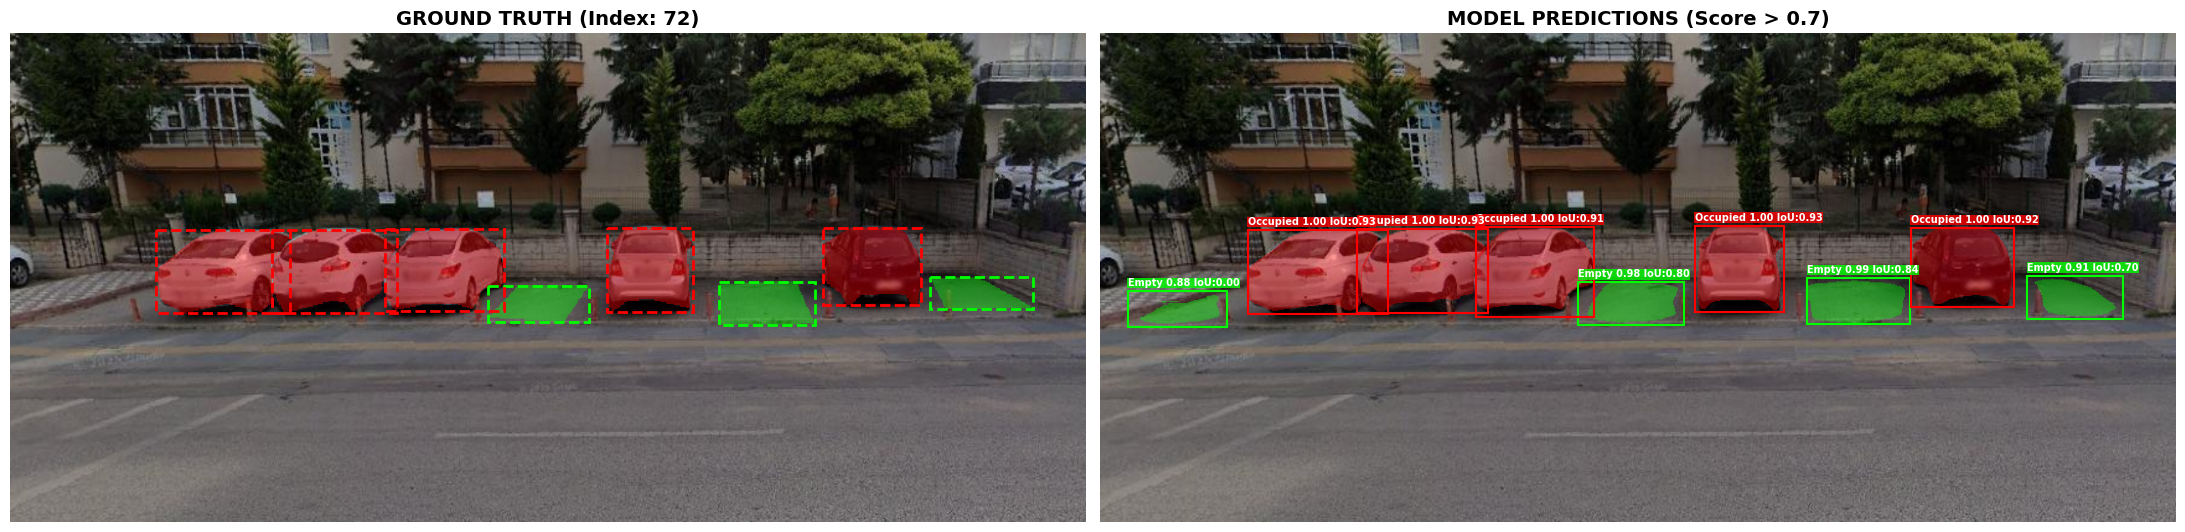

In [30]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.ops import nms, box_iou

def visualize_side_by_side_filled(model, dataset, device, index=0, score_threshold=0.7, nms_threshold=0.3):
    model.eval()
    img, target = dataset[index]

    with torch.no_grad():
        prediction = model([img.to(device)])[0]


    pred_boxes_raw = prediction["boxes"].cpu()
    pred_scores_raw = prediction["scores"].cpu()
    pred_labels_raw = prediction["labels"].cpu()

    pred_masks_raw = (prediction["masks"].cpu() > 0.5).squeeze(1).numpy()

    # Score filter
    keep = pred_scores_raw > score_threshold
    pred_boxes = pred_boxes_raw[keep]
    pred_scores = pred_scores_raw[keep]
    pred_labels = pred_labels_raw[keep]
    pred_masks = pred_masks_raw[keep]

    # NMS
    final_keep_indices = []
    for cls in [1, 2]:
        cls_mask = pred_labels == cls
        if cls_mask.any():
            cls_idx_original = torch.where(cls_mask)[0]
            keep_nms = nms(pred_boxes[cls_mask], pred_scores[cls_mask], nms_threshold)
            final_keep_indices.append(cls_idx_original[keep_nms])

    if final_keep_indices:
        final_keep_indices = torch.cat(final_keep_indices)
        final_pred_boxes = pred_boxes[final_keep_indices]
        final_pred_scores = pred_scores[final_keep_indices]
        final_pred_labels = pred_labels[final_keep_indices]
        final_pred_masks = pred_masks[final_keep_indices]
    else:
        final_pred_boxes, final_pred_scores, final_pred_labels = torch.zeros((0,4)), torch.zeros(0), torch.zeros(0)
        final_pred_masks = np.zeros((0, img.shape[1], img.shape[2]))


    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 255).astype(np.uint8) if img_np.max() <= 1.0 else img_np.astype(np.uint8)


    fig, axes = plt.subplots(1, 2, figsize=(22, 11))

    # mask creating
    def apply_mask(image, mask, color, alpha=0.4):
        for c in range(3):
            image[:, :, c] = np.where(mask == 1,
                                    image[:, :, c] * (1 - alpha) + alpha * color[c],
                                    image[:, :, c])
        return image

    # left
    img_gt = img_np.copy()
    gt_boxes = target["boxes"].cpu().numpy()
    gt_labels = target["labels"].cpu().numpy()
    gt_masks = (target["masks"].cpu() > 0).squeeze(1).numpy()

    for i, (box, label) in enumerate(zip(gt_boxes, gt_labels)):
        # color
        color = (0, 255, 0) if label == 1 else (255, 0, 0)
        color_mpl = 'lime' if label == 1 else 'red'

        # Mask
        img_gt = apply_mask(img_gt, gt_masks[i], color)
        # box
        axes[0].add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                         fill=False, color=color_mpl, linewidth=2, linestyle='--'))

    axes[0].imshow(img_gt)
    axes[0].set_title(f"GROUND TRUTH (Index: {index})", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    #right plot
    img_pred = img_np.copy()
    axes[1].set_title(f"MODEL PREDICTIONS (Score > {score_threshold})", fontsize=14, fontweight='bold')

    if len(final_pred_boxes) > 0:
        ious_matrix = box_iou(final_pred_boxes, target["boxes"].cpu())

        for i, (box, score, label) in enumerate(zip(final_pred_boxes.numpy(), final_pred_scores.numpy(), final_pred_labels.numpy())):
            max_iou = ious_matrix[i].max().item() if ious_matrix.shape[1] > 0 else 0

            #color text
            color = (0, 255, 0) if label == 1 else (255, 0, 0)
            color_mpl = 'lime' if label == 1 else 'red'
            label_text = "Empty" if label == 1 else "Occupied"

            # mask
            img_pred = apply_mask(img_pred, final_pred_masks[i], color)

            # box
            axes[1].add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                             fill=False, color=color_mpl, linewidth=1.5))


            axes[1].text(box[0], box[1]-5, f"{label_text} {score:.2f} IoU:{max_iou:.2f}",
                         color='white', fontsize=7, fontweight='bold',
                         bbox=dict(facecolor=color_mpl, alpha=0.8, pad=0.2, edgecolor='none'))

    axes[1].imshow(img_pred)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


visualize_side_by_side_filled(model, test_dataset, device, index=72, score_threshold=0.7)

In [8]:
import time
import torch

def measure_mask_rcnn_fps(model, data_loader, device=None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    model.eval()

    total_images = 0
    total_time = 0.0
    warmup_iters = 10



    with torch.no_grad():
        for i, (images, _) in enumerate(data_loader):
            # İMAGE LİST
            images = [img.to(device) for img in images]

            #   WARMUP
            if i < warmup_iters:
                _ = model(images)
                continue

            # real measumernt part
            if torch.cuda.is_available():
                torch.cuda.synchronize() # GPU synchonize

            start_time = time.perf_counter()

            # Inference
            _ = model(images)

            if torch.cuda.is_available():
                torch.cuda.synchronize()

            end_time = time.perf_counter()


            total_time += (end_time - start_time)
            total_images += len(images)



    # computing metrics
    if total_images == 0:
        print("there is no image")
        return None

    avg_inference_time = total_time / total_images
    fps = 1 / avg_inference_time

    print("\n" + "="*30)
    print(f"RESULT")
    print("-" * 30)
    print(f"total images: {total_images}")
    print(f"average latency: {avg_inference_time*1000:.2f} ms")
    print(f"FPS: {fps:.2f}")
    print("="*30)

    return fps


fps = measure_mask_rcnn_fps(model, test_loader)


RESULT
------------------------------
total images: 326
average latency: 89.40 ms
FPS: 11.19


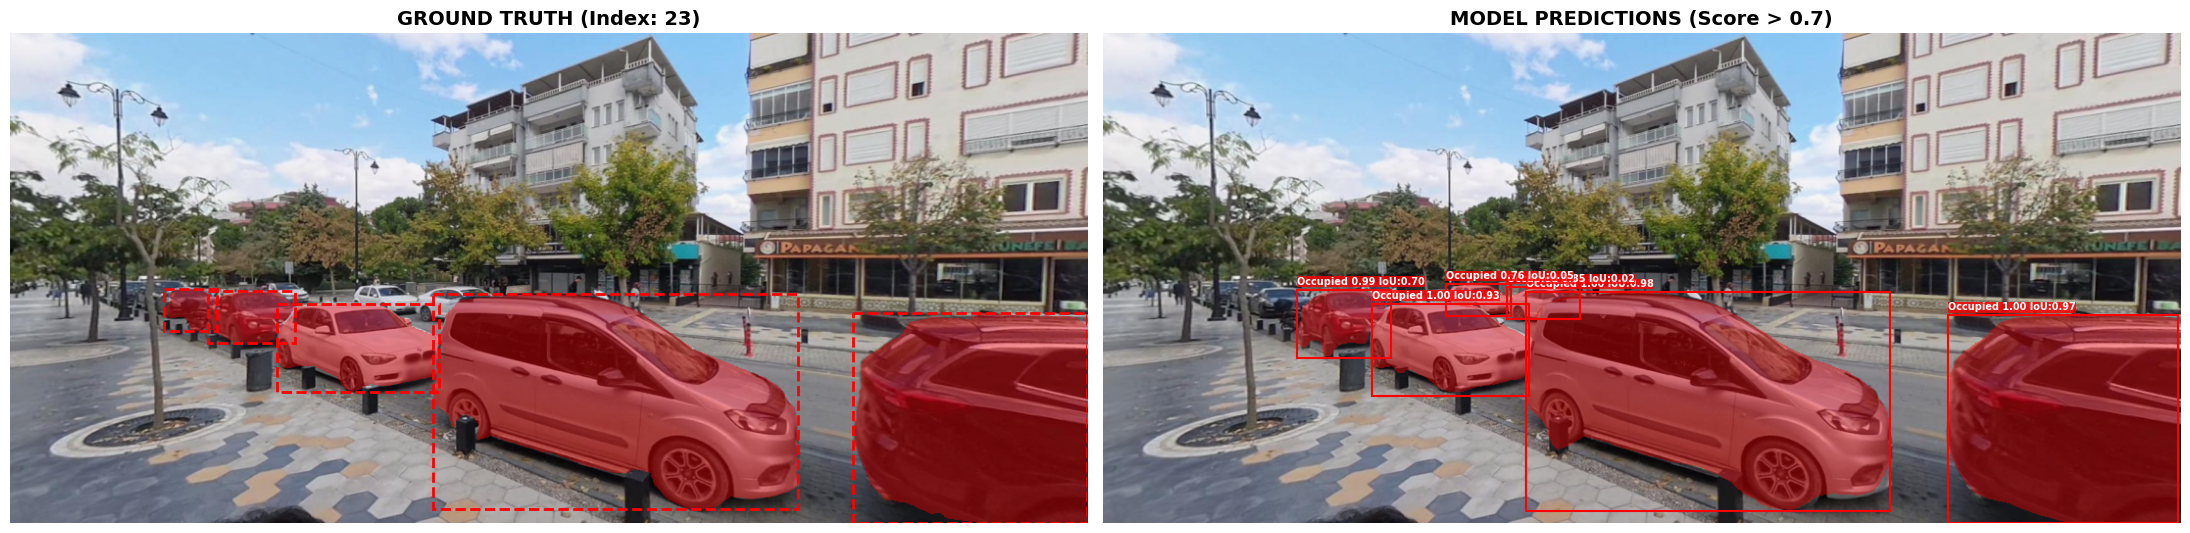

In [28]:
visualize_side_by_side_filled(model, test_dataset, device, index=23, score_threshold=0.7)

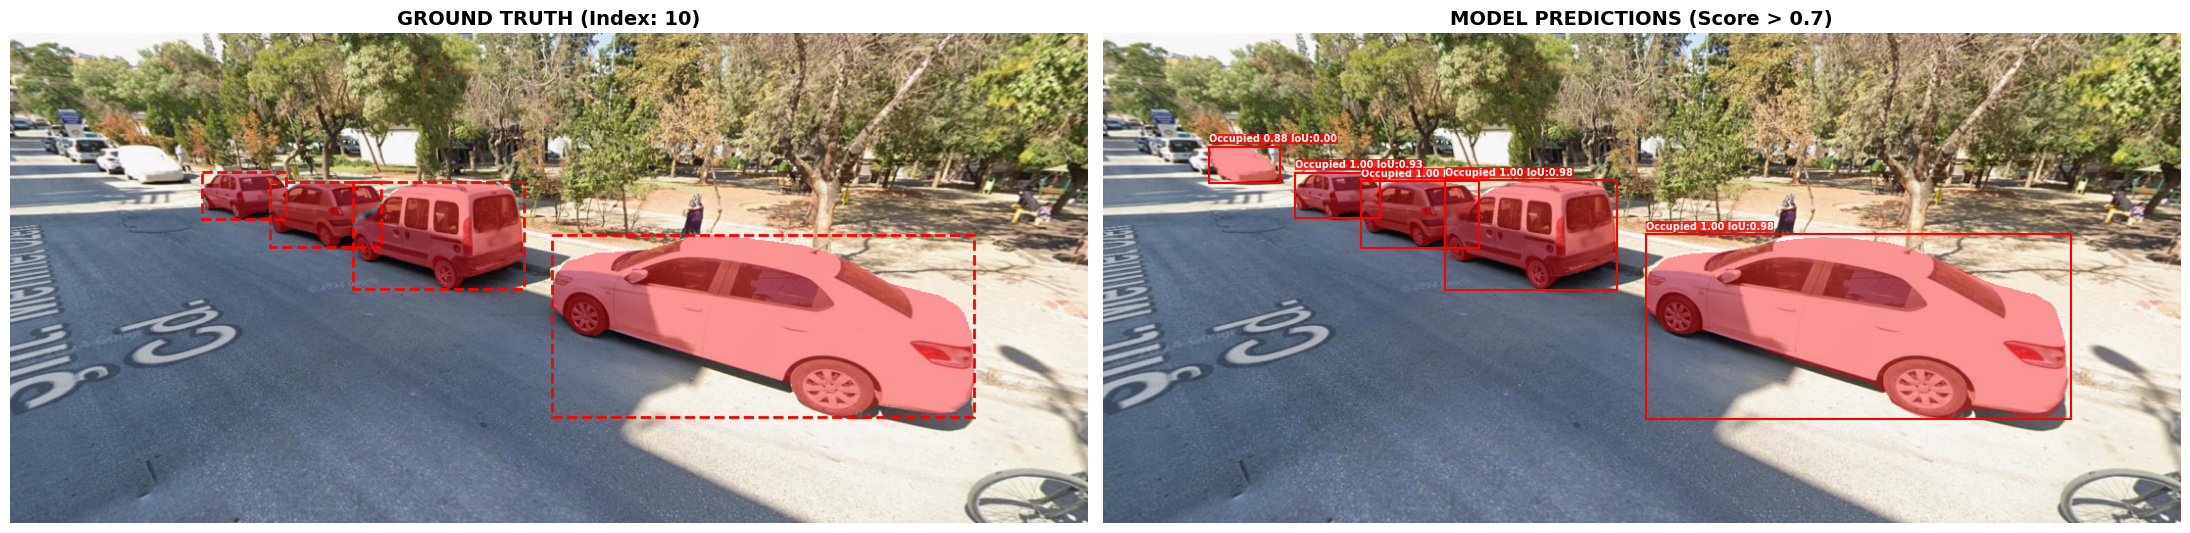

In [20]:
visualize_side_by_side_filled(model, test_dataset, device, index=10, score_threshold=0.7)

In [29]:
for i in range(30):
  visualize_side_by_side_filled(model, test_dataset, device, index=i, score_threshold=0.7)

Output hidden; open in https://colab.research.google.com to view.